In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle
from prepare_data import PrepareData
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\training\prepare_data.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("6H")


Get Data

In [2]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

In [ ]:
attr = "api_temp"

# Training sarima to predict the temperature 

## EDA

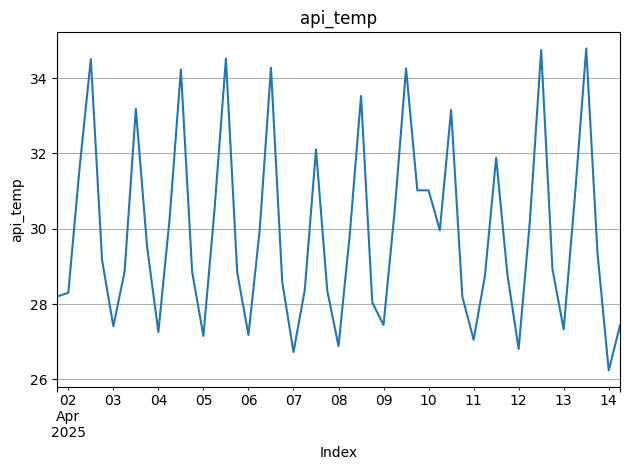

In [4]:
plt.figure()  # Create a new figure for each plot
df['api_temp'].plot()
plt.title('api_temp')
plt.xlabel("Index")  # or "Date" if it's time series
plt.ylabel('api_temp')
plt.grid(True)
plt.tight_layout()
plt.show()

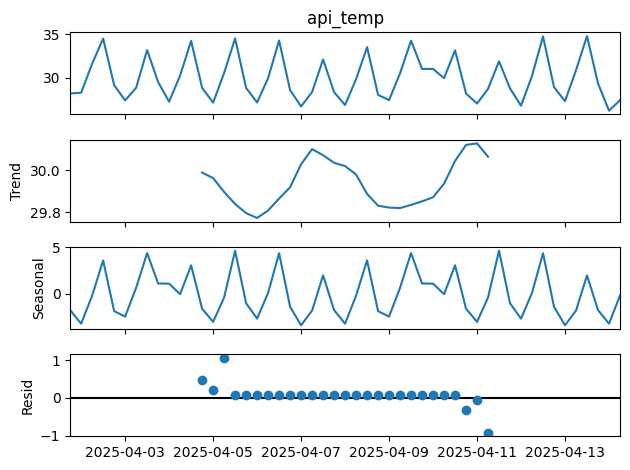

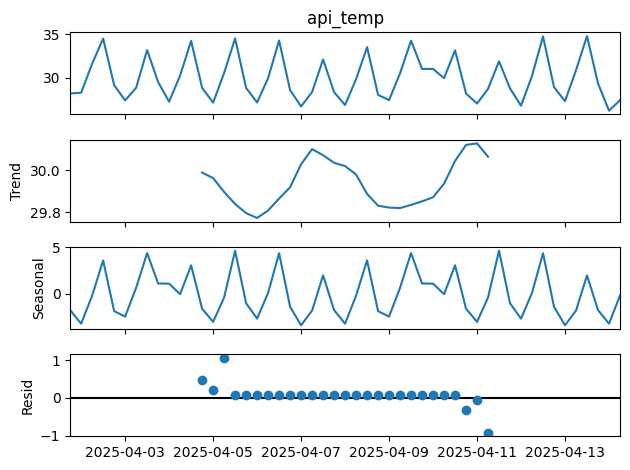

In [5]:
seasonal_decompose(df[attr].interpolate(), model="additive").plot()

In [6]:
diffed_data = df[attr].dropna()
diff = 0
while True:
    result = adfuller(diffed_data)
    if result[1] < 0.05 or result[0] < result[4]["5%"]:
        print(f"d={diff}")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        for key, value in result[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')
        break
    diffed_data = diffed_data.diff().dropna()
    diff+=1

d=0
ADF Statistic: -3.474478727683749
p-value: 0.008667241762804695
Critial Values:
   1%, -3.596635636000432
Critial Values:
   5%, -2.933297331821618
Critial Values:
   10%, -2.6049909750566895


Use d=0.

### Find the P parameter

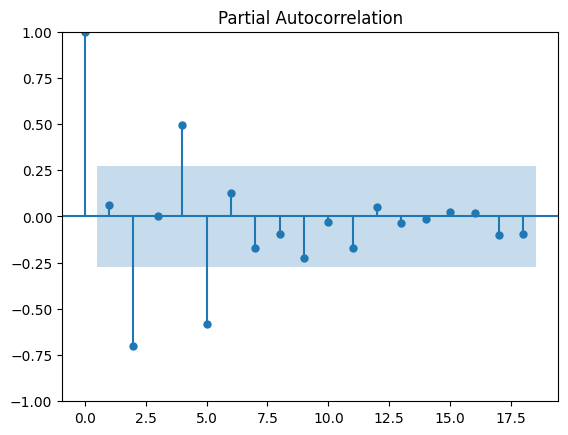

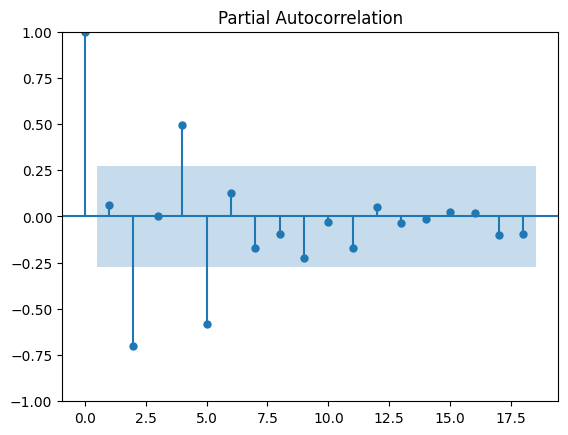

In [7]:
plot_pacf(diffed_data)

Use p = 4

### Find the Q parameter

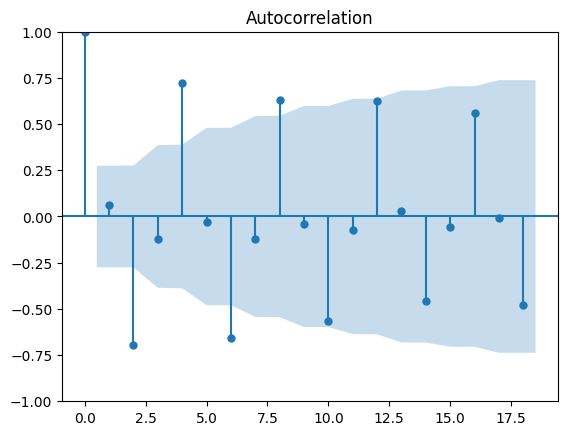

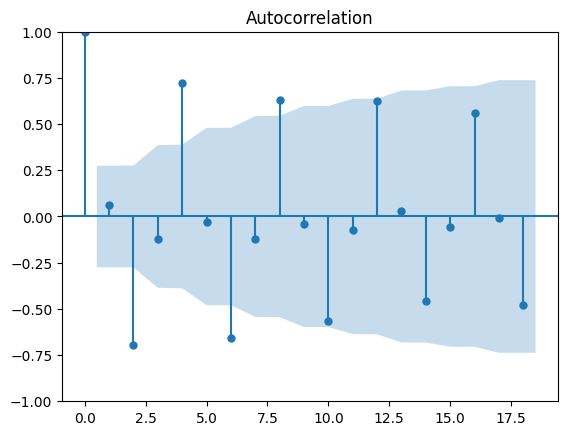

In [8]:
plot_acf(diffed_data)

Use q = 5

## Pre-Processing

The missing value is already filled using KNN Imputer

## Train the model

In [ ]:
# Use auto_arima to find the best model parameters
model = auto_arima(
    train_data[attr],
    seasonal=True,
    m=4,  # Seasonality every day
    d=0, #
    D=0,
    max_p=5,
    max_q=5,
    max_P=5,
    max_Q=5,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=114.090, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=139.135, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=105.354, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=122.683, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=281.521, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=141.131, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=136.948, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=125.525, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=125.161, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=128.658, Time=0.31 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=97.822, Time=0.12 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=122.626, Time=0.22 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=103.214, Time=0.20 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=123.341, Time=0.03 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, T

auto arima gives p=2 and q=2 while using m=4. Contradicting our findings above. We also cannot get the model to run with p=4 and q=5.

In [10]:
model_attr = SARIMAX(
    endog=train_data[attr], order=(2, 0, 2), seasonal_order=(1, 0, 0, 4)
)
attr_results = model_attr.fit()

steps = len(test_data)

attr_prediction = attr_results.get_forecast(
    steps=steps
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data[attr].count()),
)
attr_prediction.index = test_data.index[:steps]
attr_prediction.columns = ["predicted"]

In [11]:
attr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           api_temp   No. Observations:                   29
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 4)   Log Likelihood                 -43.228
Date:                            Wed, 30 Apr 2025   AIC                             98.457
Time:                                    16:35:44   BIC                            106.661
Sample:                                04-01-2025   HQIC                           101.026
                                     - 04-08-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9907      0.441      2.249      0.025       0.127       1.854
ar.L2          0.0093      0.439      0.021      0.983      -0.851       0.870
ma.L1         -0.2386      0.382     -0.624      0.532      -0.988       0.511
ma.L2         -0.7545      0.228     -3.304      0.001      -1.202      -0.307
ar.S.L4        0.9717      0.033     29.207      0.000       0.906       1.037
sigma2         0.6634      0.287      2.308      0.021       0.100       1.227
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.49   Prob(JB):                         0.96
Heteroskedasticity (H):               0.82   Skew:                            -0.03
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

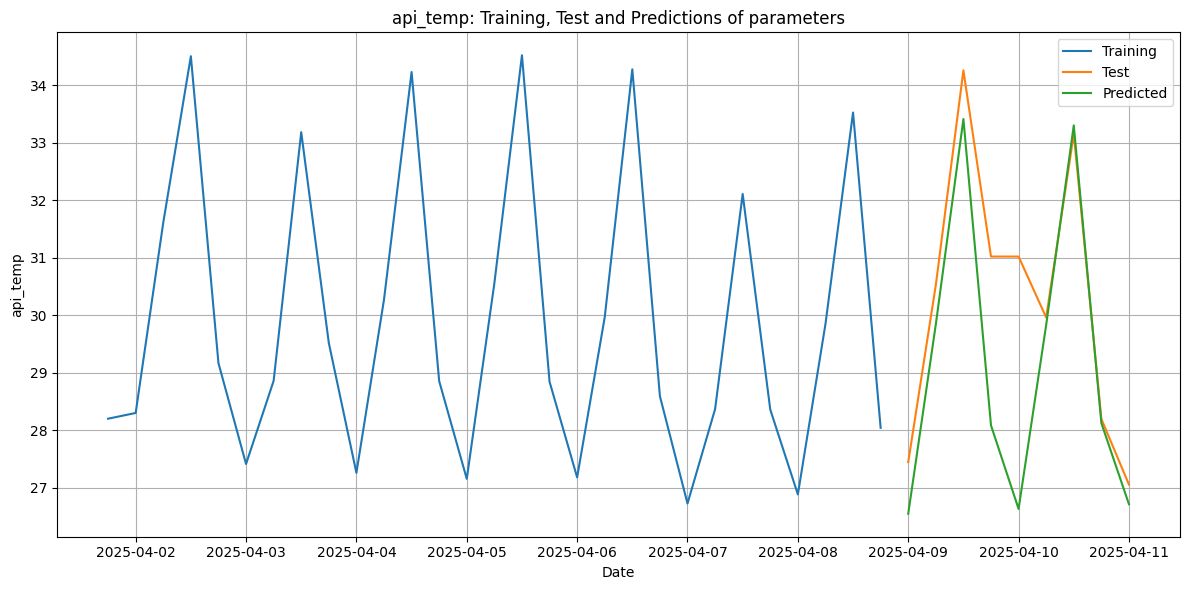

RMSE is :  1.8270921599473067


In [12]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data[attr], label="Training")
plt.plot(test_data.index, test_data[attr], label="Test")
plt.plot(test_data.index, attr_prediction, label="Predicted")

plt.legend()
plt.xlabel("Date")
plt.ylabel(attr)
plt.title(f"{attr}: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE is : ", root_mean_squared_error(test_data[attr], attr_prediction))

## Save the model using pickle

In [ ]:
with open(f"../exports/{attr}_sarima.pkl", "wb") as file:
    pickle.dump(attr_results, file)